In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from scipy import signal

ModuleNotFoundError: No module named 'torch'

In [2]:
from running import pipeline_factory
from utils import utils
from datasets.data import data_factory
from models.ts_transformer import model_factory
from optimizers import get_optimizer

In [3]:
MODEL_DIM=128

In [4]:
config = {
    'data_dir': '../data', 'resume': False, 'change_output': False, 'save_all': False,
    'experiment_name': 'bat_pretrained', 'no_timestamp': False, 'records_file': 'Imputation_records.xls',
    'console': False, 'print_interval': 1, 'n_proc': -1, 'num_workers': 0, 'seed': None,
    'limit_size': None, 'test_only': None, 'labels': None, 'test_from': None,
    'test_ratio': 0, 'val_ratio': 0.2, 'pattern': None, 'val_pattern': None,
    'test_pattern': None, 'normalization': 'standardization', 'norm_from': None, 'subsample_factor': None,
    'task': 'imputation', 'masking_ratio': 0.15, 'mean_mask_length': 3, 'mask_mode': 'separate',
    'mask_distribution': 'geometric', 'exclude_feats': None, 'mask_feats': [0, 1], 'start_hint': 0.0,
    'end_hint': 0.0, 'harden': False, 'epochs': 10, 'val_interval': 2, 'lr': 0.001,
    'lr_step': [1000000], 'lr_factor': [0.1], 'batch_size': 1, 'l2_reg': 0, 'global_reg': False,
    'key_metric': 'loss', 'freeze': False, 'model': 'transformer', 'max_seq_len': None, 'data_window_len': None,
    'd_model': MODEL_DIM, 'dim_feedforward': 256, 'num_heads': 8, 'num_layers': 3, 'dropout': 0.1, 'pos_encoding': 'learnable',
    'activation': 'gelu', 'normalization_layer': 'BatchNorm',
}

DATA_DIR = '../../data'
GPU_NUM = '2'

In [5]:
data_class = data_factory['bat']
my_data = data_class(DATA_DIR)

In [7]:
ID = 'bat_pretrained_2023-11-13_21-50-44_Zyd'
LOAD_MODEL = f'../experiments/{ID}/checkpoints/model_best.pth'

model = model_factory(config, my_data)

optim_class = get_optimizer('RAdam')
optimizer = optim_class(model.parameters(), lr=config['lr'], weight_decay=0)

## Load model
model, optimizer, start_epoch = utils.load_model(model, LOAD_MODEL, optimizer,
    config['change_output'],
    config['lr'],
    config['lr_step'],
    config['lr_factor'])

Loaded model from ../experiments/bat_pretrained_2023-11-13_21-50-44_Zyd/checkpoints/model_best.pth. Epoch: 90


/home/nsagan/autumn23-batlab-project/transformer-interpolation/MaskSpec_forked/env/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [8]:
dataset_class, collate_fn, runner_class = pipeline_factory(config)
test_dataset = dataset_class(my_data, my_data.all_IDs)

test_loader = DataLoader(dataset=test_dataset,
                            batch_size=config['batch_size'],
                            shuffle=False,
                            num_workers=config['num_workers'],
                            pin_memory=True,
                            collate_fn=lambda x: collate_fn(x, max_len=model.max_len))

In [9]:
## Setup pytorch
device = torch.device(('cuda:' + GPU_NUM) if (torch.cuda.is_available() and GPU_NUM != '-1') else 'cpu')
print("Using device: {}".format(device))
if device == 'cuda':
    print("Device index: {}".format(torch.cuda.current_device()))


Using device: cuda:2


In [ ]:
def test_imputation(X, model, device, mask):
    

In [13]:
def plot_specgram(Sx, nfft=256, stride=128, FS=250_000):
    plt.figure(figsize=(15, 4))
    plt.imshow(np.flip(Sx, axis=0), aspect='auto')
    plt.colorbar()
    locs, labels = plt.yticks()
    labels = np.array(list(map(lambda x: float(x.get_text().replace('−', '-')), labels)))
    freqs = np.round(FS/1000 / nfft * (Sx.shape[0] - labels))
    
    plt.yticks(locs[1:-1], freqs[1:-1])
    plt.show()

In [19]:
X, targets, target_masks, padding_masks, IDs = next(iter(test_loader))

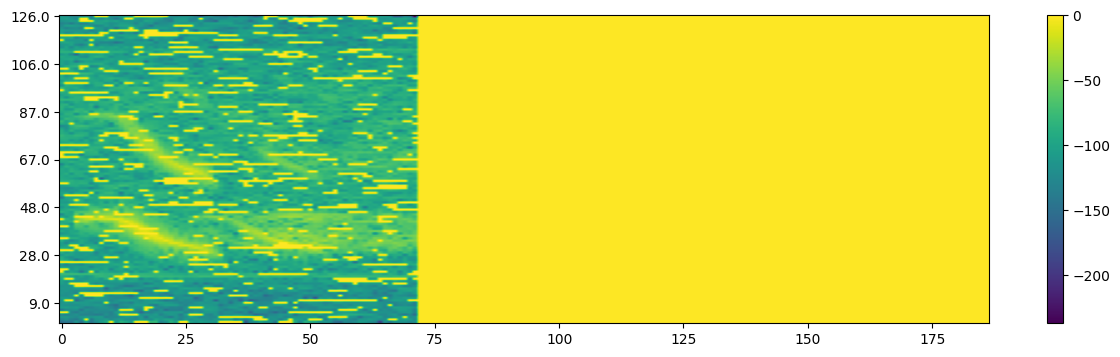

In [20]:
plot_specgram(X[0].numpy().T)

In [22]:
model = model.to(device)
target_masks = target_masks.to(device)  # 1s: mask and predict, 0s: unaffected input (ignore)
padding_masks = padding_masks.to(device)  # 0s: ignore

predictions = model(X.to(device), padding_masks)  # (batch_size, padded_length, feat_dim)

TypeError: TransformerBatchNormEncoderLayer.forward() got an unexpected keyword argument 'is_causal'